In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
import statsmodels.formula.api as smf
from numpy.linalg import LinAlgError
import warnings

# Load data

In [2]:
with warnings.catch_warnings(): # Excel Header cannot be parsed
    warnings.simplefilter("ignore")
    data = pd.read_excel('./data/SAh_OKIE_DB_20250303.xlsx', sheet_name=0, header=0, engine='openpyxl')
    med = pd.read_excel('./data/SAh_OKIE_DB_meds_20250217.xlsx', sheet_name=0, header=0, engine='openpyxl')

# Preprocessing

### Primary Outcome
COC Decision, Multiclass

In [3]:
coc_mapping = {
    0: 0, # Back Home
    1: 3, # Nursing Home
    2: 3, # Nursing Home
    3: 2, # Rehabilitation
    4: 2, # Rehabilitation
    5: 1, # Acute Geriatric Clinic
    6: 4 # Other Acute Clinic
}

In [4]:
data['coc_gt'] = data['dis_geriatrician_0'].map(coc_mapping)
data['coc_soc'] = data['discharge_general'].map(coc_mapping)

#### COC appropriate (Y/N)
binary, 1 = Yes, 0 = No

In [5]:
def map_coc_appropriate(row):
    if pd.isna(row['coc_gt']):
        return np.nan # If ground truth is missing
    else:
        return row['coc_gt'] == row['coc_soc']

In [6]:
data['coc_appropriate'] = data.apply(map_coc_appropriate, axis=1)

### Secondary Outcomes

In [7]:
def binarize_endpoint(row, col_pre, col_post, inverse=False):
    if pd.isna(row[col_pre]) or pd.isna(row[col_post]): # if either are missing
        return np.nan
    if row[col_pre] == row[col_post]: # If outcome score stayed the same
        return 0
    if row[col_pre] < row[col_post]: # If outcome score went up
        return 0 if inverse==False else 1
    if row[col_pre] > row[col_post]: # If outcome score went down
        return 1 if inverse==False else 0
    else: # Exception handling
        return np.nan

#### Barthel Index change
binary, 0 = better/same, 1 = worse

In [8]:
data['bi_decline_3mo'] = data.apply(
    binarize_endpoint, # better/same: 0, worse: 1
    col_pre='bi_prior',
    col_post='bi_followup',
    axis=1
)

In [9]:
data['bi_decline_15mo'] = data.apply(
    binarize_endpoint, # better/same: 0, worse: 1
    col_pre='bi_prior',
    col_post='bi_fu12',
    axis=1
)

#### CHARMI
Ordinal Scale: 0-10 \
Extra Category "wheelchair" encoded as 11

In [10]:
charmi_list = ['charmi_prior', 'charmi_postop_1', 'charmi_postop_3', 'charmi_postop_5', 'charmi_postop_7', 'charmi_followup']
data[charmi_list] = data[charmi_list].replace({11: np.nan}) # Replaces "wheelchair" with None.

In [11]:
data['charmi_fu12'] = data['charmi_fu12'].map(lambda x: np.nan if x == 'W' else x)
data['charmi_fu12'] = pd.to_numeric(data['charmi_fu12'])

#### CHARMI change
binary, 0 = better/same, 1 = worse

In [12]:
data['charmi_decline_3mo'] = data.apply(
    binarize_endpoint, # better/same: 0, worse: 1
    col_pre='charmi_prior',
    col_post='charmi_followup',
    axis=1
)

In [13]:
data['charmi_decline_15mo'] = data.apply(
    binarize_endpoint, # better/same: 0, worse: 1
    col_pre='charmi_prior',
    col_post='charmi_fu12',
    axis=1
)

#### New Mobility Scale (NMS) change
binary, 0 = better/same, 1 = worse

In [14]:
data['life_space_decline_3mo'] = data.apply(
    binarize_endpoint, # better/same: 0, worse: 1
    col_pre='life_space_prior',
    col_post='life_space_followup',
    axis=1
)

In [15]:
data['life_space_decline_15mo'] = data.apply(
    binarize_endpoint, # better/same: 0, worse: 1
    col_pre='life_space_prior',
    col_post='life_space_fu12',
    axis=1
)

#### Social Grade (Y/N)
binary, 1 = Yes, 0 = No

In [16]:
def map_social_grade(row, col):
    if row[col] == 98: # Social Grade was applied for, but the decision is pending.
        return 0
    if row[col] == 100: # Participant refused to answer
        return np.nan
    else:
        return row[col]

In [17]:
data['social_grade'] = data.apply(map_social_grade, col='social_grade', axis=1)

In [18]:
data['social_grade_followup'] = data.apply(map_social_grade, col='social_followup_grade', axis=1)

#### Social Grade level
Ordinal Scale: 0-5

In [19]:
def map_social_gradelevel(row, grade, gradelevel):
    if row[grade] == 0: # No social grade, or social grade was applied for, but the decision is pending.
        return 0
    if pd.isna(row[grade]): # Participant refused to answer, or missing value
        return np.nan
    else:
        return row[gradelevel]

In [20]:
data['social_gradelevel'] = data.apply(
    map_social_gradelevel,
    grade='social_grade',
    gradelevel='social_gradelevel',
    axis=1
)

In [21]:
data['social_gradelevel_followup'] = data.apply(
    map_social_gradelevel,
    grade='social_grade_followup',
    gradelevel='social_followup_gradelevel',
    axis=1
)

In [22]:
data['social_gradelevel_fu12'] = data.apply(
    map_social_gradelevel,
    grade='social_gradez',
    gradelevel='social_gradeb',
    axis=1
)

#### Social Grade level change
binary, 0 = lower/same, 1 = increase

In [23]:
data['social_gradelevel_increase_3mo'] = data.apply(
    binarize_endpoint, # lower/same: 0, increase: 1
    col_pre='social_gradelevel',
    col_post='social_gradelevel_followup',
    inverse=True,
    axis=1
)

In [24]:
data['social_gradelevel_increase_15mo'] = data.apply(
    binarize_endpoint, # lower/same: 0, increase: 1
    col_pre='social_gradelevel',
    col_post='social_gradelevel_fu12',
    inverse=True,
    axis=1
)

#### Nursing service
Ordinal Scale 0-3 \
0 = home without support, 1 = home with support, 2 = assisted living, 3 = nursing home

In [25]:
def map_nursing_service(row, accomodation, help):
    # Mapping with decreasing need for nursing services
    if row[accomodation] <=1 and row[help] == 0:
        return 0 # Home without support
    if row[accomodation] <=1 and row[help] == 1:
        return 1 # Home with support
    if row[accomodation] == 2:
        return 2 # assisted living
    if row[accomodation] == 4:
        return 3 # nursing home
    else: # inconclusive or missing data
        return np.nan

In [26]:
data['nursing_service'] = data.apply(
    map_nursing_service,
    accomodation = 'social_accomodation',
    help = 'social_help',
    axis=1
)

In [27]:
data['nursing_service_followup'] = data.apply(
    map_nursing_service,
    accomodation = 'social_followup_accomodation',
    help = 'social_followup_help',
    axis=1
)

#### Nursing service change
binominal scale 0 = lower/same, 1 = increase

In [28]:
data['nursing_service_increase_3mo'] = data.apply(
    binarize_endpoint, # lower/same: 1, increase: 0
    col_pre='nursing_service',
    col_post='nursing_service_followup',
    inverse=True,
    axis=1
)

#### Institutionalization (Y/N)
binary, 1 = Yes, 0 = No

In [29]:
def map_institution(row, col):
    if row[col] == 4:
        return 1 # Living in institution
    if row[col] in (0, 1, 2, 3, 98):
        return 0 # Not living in institution
    else: # 100 (denies answer), 101 (cannot answer)
        return np.nan

In [30]:
data['institution'] = data.apply(map_institution, col='social_accomodation', axis=1)

In [31]:
data['institution_followup'] = data.apply(map_institution, col='social_followup_accomodation', axis=1)

In [32]:
# correcting wrong data
data.loc[data['id']==11127, 'institution_followup'] = 1
data.loc[data['id']==12008, 'institution'] = 0

In [33]:
def map_institution_fu12(row):
    if row['social_livingz'] in (1, 2):
        return 1 # Living in institution
    if row['social_livingz'] in (3, 4, 5, 6, 7, 8, 9):
        return 0 # Not living in institution
    else:
        return np.nan

In [34]:
data['institution_fu12'] = data.apply(map_institution_fu12, axis=1)

#### Institutionalization change (Y/N)
binary, 1 = Yes, 0 = No/same

In [35]:
def map_institution_change(row, col):
    if pd.isna(row[col]) or pd.isna(row['institution']):
        return np.nan
    if row[col] == row['institution']:
        return 0
    if (row[col] == 0) and (row['institution'] == 1):
        return 0
    if (row[col] == 1) and (row['institution'] == 0):
        return 1
    else:
        return np.nan

In [36]:
data['institution_change_3mo'] = data.apply(map_institution_change, col='institution_followup', axis=1)

In [37]:
data['institution_change_15mo'] = data.apply(map_institution_change, col='institution_fu12', axis=1)

In [38]:
data.loc[
    (data['institution_change_15mo'] == True) | (data['institution_change_3mo'] == True),
    ['id', 'institution', 'institution_followup', 'institution_fu12', 'coc_appropriate']
]

,id,institution,institution_followup,institution_fu12,coc_appropriate
90,11096,0.0,1.0,NaN,True
124,11133,0.0,1.0,1.0,True
128,11137,0.0,1.0,0.0,True
138,12008,0.0,0.0,1.0,True


#### Readmission (Y/N)
within 2d or 30d combined

In [39]:
def map_readmission(row):
    if row['d_c_wiedervor2t_trigger'] == 'true' or row['d_c_wiederauf90t_trigger'] == 'true':
        return 1  # Readmitted to UKU within 3mo
    if row['d_c_wiedervor2t_trigger'] == 'false' and row['d_c_wiederauf90t_trigger'] == 'false':
        return 0  # No readmission to UKU within 3mo
    else:
        return np.nan

In [40]:
data['readmission_3mo'] = data.apply(map_readmission, axis=1)

### Explanatory Variables

#### Surgery
one-hot-encodings for UCH, AVC and URO \
binary, 1 = Yes, 0 = No

In [41]:
data = pd.get_dummies(data, columns=['station'], prefix='', prefix_sep='')

#### Living alone (Y/N)
binary, 1 = Yes, 0 = No

In [42]:
def map_living_alone(row, col):
    if row[col] == '0':
        return 1 # Living alone
    if row[col] in ('1', '2', '3', '5', '1,2', '1,2,3', '1,3', '98'):
        return 0 # Not living alone
    else:
        return np.nan

In [43]:
data['living_alone'] = data.apply(map_living_alone, col='social_living',  axis=1)

In [44]:
data['living_alone_followup'] = data.apply(map_living_alone, col='social_followup_living', axis=1)

#### Number of Medications
Discrete variable (n)

In [45]:
number_of_medications_dict={}
med = med[med['slot'].str.contains('preop')] # Only pre-operative medication
med = med[med['freq_type'] != 'bb'] # drop on-demand medication
for ID in data['id']:
    number_of_medications_dict[ID] = med[med['ID'] == ID].shape[0]
data['number_of_medications'] = data['id'].map(number_of_medications_dict)

#### Dementia (Y/N)
binary, 1 = Yes, 0 = No

In [46]:
dementia_anamnesis = (data['comorbidity_2_dementia'] > 0) & (data['comorbidity_2_dementia'] < 99) # yes = 1, 2; no = 0, 99 
dementia_anasthesia = (data['comorbidity_1_dementia'] == 1)
data['dementia'] = 0
data.loc[dementia_anamnesis | dementia_anasthesia, 'dementia'] = 1 # Either anamnesis or anaesthesia say dementia is present

#### Time to Surgery
Continous variable (hour)

In [47]:
data['time_to_operation'] = data['time_to_operation']/60 # in hours

#### Length of Stay on ICU
Continuous variable (min)

In [48]:
data.loc[data['los_icu'] == " ", 'los_icu'] = np.nan
data['los_icu'] = pd.to_numeric(data['los_icu'].str.replace(',', '.')) # in hours

#### Falls (Y/N)
within last 3 months \
binary, 1 = Yes, 0 = No

In [49]:
data['falls'] = data['falls_1']
data.loc[data['falls'].isin([99, 100, 101]) , 'falls'] = np.nan
data.loc[data['falls'] > 0 , 'falls'] = 1

In [50]:
data['falls_followup'] = data['medical_history_2']
data.loc[data['falls_followup'].isin([99, 100, 101]) , 'falls_followup'] = np.nan
data.loc[data['falls_followup'] > 0 , 'falls_followup'] = 1

### Drop-Outs

In [51]:
data[data['coc_appropriate'].isna()][['id', 'dropout', 'dropout_reason']]

,id,dropout,dropout_reason
5,11006,1.0,0.0
12,11013,1.0,1.0
68,11072,1.0,1.0
130,11139,1.0,1.0
133,12003,1.0,1.0
158,13005,1.0,0.0
160,13007,1.0,1.0
164,13011,1.0,1.0
171,13019,1.0,0.0


# Select Variables

In [52]:
variables = [
    # Primary Outcome
    'coc_gt', # COC ground truth
    'coc_soc', # COC standard of care
    'coc_appropriate', # Is COC suggestion and real discharge destination equivalent? Y/N
    
    # Secondary Outcomes (binarized)
    # 3 months follow-up
    'social_gradelevel_increase_3mo', # Change Care level, 0: lower/same, 1: increase
    'nursing_service_increase_3mo', # Change Nursing service, 0: lower/same, 1: increase
    'bi_decline_3mo', # Change BI, 0: better/same, 1: decline
    'charmi_decline_3mo', # Change CHARMI, 0: better/same, 1: decline
    'life_space_decline_3mo', # Change NMS, 0: better/same, 1: decline
    'readmission_3mo', # Readmission within 3mo
    'institution_change_3mo', # Insitutionalization, 0: No/same, 1: new institutionalization
    # 15 months follow-up
    'social_gradelevel_increase_15mo', # Change Care level, 0: lower/same, 1: increase
    'bi_decline_15mo', # Change BI, 0: better/same, 1: decline
    'charmi_decline_15mo', # Change CHARMI, 0: better/same, 1: decline
    'life_space_decline_15mo', # Change NMS, 0: better/same, 1: decline
    'institution_change_15mo', # Insitutionalization, 0: No/same, 1: new institutionalization

    # Group Variables
    'UCH', # Trauma Surgery
    'AVC', # General & Visceral Surgery
    'URO', # Urology
        
    # Explanatory Variables
    'adm_age', # Age at the time of operation
    'sex', # w:0 m:1
    'moca_preop', # Cognition MoCA 5min preop
    'phq4_preop', # PHQ4 preop
    'phq4_followup', # PHQ4 3 months
    'cfs_prior', # CFS preop (nurse)
    'nursing_service', # 0 = no support, 1 = support at home, 2 = assisted living, 3 = nursing home
    'living_alone', # Living alone (Y/N) prior
    'bmi_preop', # Nutrition (BMI)
    'malnutrition', # Nutrition Risk Screening (NRS) preop
    'number_of_medications', # Number of medications preop
    'comorbidity_1_asa', # ASA
    'isar', # ISAR
    'falls', # Has fallen in the last 3 months preop # CL: Too much bias, as nearly all Trauma patients have fallen?
    'los_days', # length of stay in days
    'time_to_operation', # Time-to-surgery in hours
    'cut_to_suture', # Cut-to-suture time in min
    'los_icu', # Length of stay on ICU in min
    'op_type', # 0:elective, 1:emergency
    'dementia', # Dementia in Anamnesis or According to Anaesthesist
    'bi_prior', # Barthel index prior
    'life_space_prior', # New mobility score preop
    'charmi_prior', # CHARMI prior
    'social_gradelevel', # Care level X/5 on admission
]

In [53]:
df = data[variables].copy()
df = df.dropna(subset=['coc_appropriate'])
df.to_csv('./OKIE_data.csv', index=False)

# Analysis

In [54]:
explanatory_variables = {
    'adm_age': 'continuous',
    'sex': 'binary',
    'UCH': 'binary',
    'AVC': 'binary',
    'URO': 'binary',
    'bmi_preop': 'continuous',
    'malnutrition': 'binary',
    'moca_preop': 'ordinal',
    'dementia': 'binary',
    'phq4_preop': 'ordinal',
    'isar': 'ordinal',
    'cfs_prior': 'ordinal',
    'comorbidity_1_asa': 'ordinal',
    'number_of_medications': 'discrete',
    'social_gradelevel': 'ordinal',
    'nursing_service': 'ordinal',
    'living_alone': 'binary',
    'bi_prior': 'ordinal',
    'charmi_prior': 'ordinal',
    'life_space_prior': 'ordinal',
    'falls': 'binary',
    'op_type': 'binary',
    'time_to_operation': 'continuous',
    'cut_to_suture': 'continuous',
    'los_icu': 'continuous',
    'los_days': 'discrete',
}

explanatory_variable_names = [
    'Age (years)',
    'Sex (male)',
    'Trauma Surgery (Yes/No)',
    'General & Visceral Surgery (Yes/No)',
    'Urology (Yes/No)',
    'BMI (kg/m²)',
    'NRS (Yes/No)',
    'MoCA 5-min (score)',
    'Dementia (Yes/No)',
    'PHQ4 (score)',
    'ISAR (score)',
    'CFS (score)',
    'ASA (class)',
    'Number of Medications (n)',
    'Social Grade Level (class)',
    'Nursing Services (class)',
    'Living Alone (Yes/No)',
    'Barthel Index (score)',
    'CHARMI (score)',
    'NMS (score)',
    'Falls (Yes/No)',
    'Emergency OP (Yes/No)',
    'Time to OP (hours)',
    'Cut-to-Suture Time (minutes)',
    'Length of Stay ICU (minutes)',
    'Length of Stay (days)',
    ]

outcomes = {
    # 3 months follow-up
    'Care Grade Level (3 months)': 'social_gradelevel_increase_3mo',
    'Nursing Service (3 months)': 'nursing_service_increase_3mo',
    'Barthel Index (3 months)': 'bi_decline_3mo',
    'CHARMI (3 months)': 'charmi_decline_3mo',
    'New Mobility Scale (3 months)': 'life_space_decline_3mo',
    'Readmission (3 months)': 'readmission_3mo',
    'Institutionalization (3 months)': 'institution_change_3mo',
    # 12 months follow-up
    'Care Grade Level (12 months)': 'social_gradelevel_increase_12mo',
    'Barthel Index (12 months)': 'bi_decline_12mo',
    'CHARMI (12 months)': 'charmi_decline_12mo',
    'New Mobility Scale (12 months)': 'life_space_decline_12mo',
    'Institutionalization (12 months)': 'institution_change_12mo',
}

In [55]:
corr_matrix = df[['coc_appropriate']+list(explanatory_variables.keys())]
corr_matrix.columns = ['COC appropriate']+explanatory_variable_names
corr_matrix = corr_matrix.corr()
corr_matrix.to_csv('./data/supplementary_table1.csv')

## Primary Endpoint

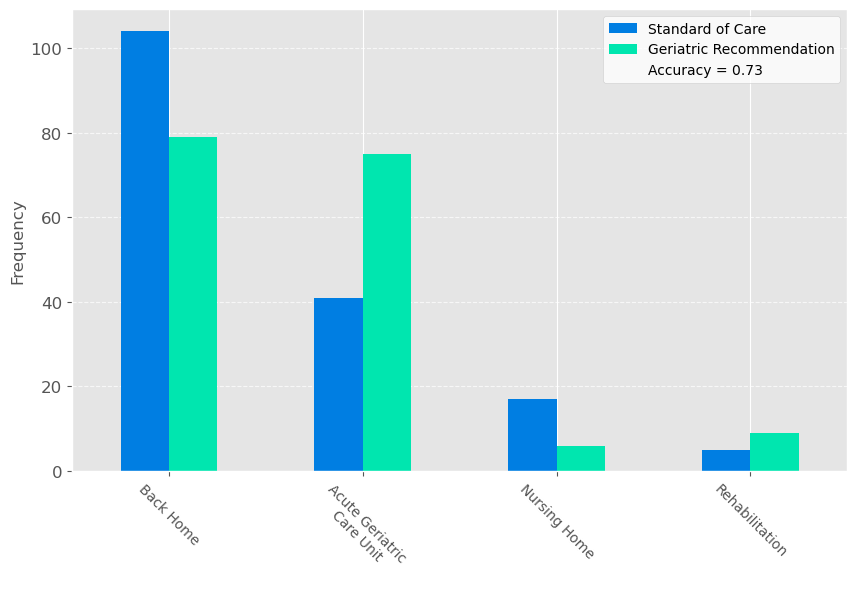

In [56]:
accuracy = df['coc_appropriate'].mean().round(2)

coc_fig_dict = {
    0: 'Back Home',
    1: 'Acute Geriatric \nCare Unit',
    2: 'Rehabilitation',
    3: 'Nursing Home'
}

# Make DataFrame for Figure
coc_fig_df = pd.DataFrame()
coc_fig_df['Standard of Care'] = df['coc_soc'].map(coc_fig_dict).value_counts()
coc_fig_df['Geriatric Recommendation'] = df['coc_gt'].map(coc_fig_dict).value_counts()

# Make Figure
plt.style.use('ggplot')
colors = ['#007ee2', '#00e6af']
ax = coc_fig_df.plot.bar(xlabel='', rot=-45, color=colors, figsize=(10,6))
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
custom_legend_entry = Line2D([0], [0], linestyle='', label=f'Accuracy = {accuracy}') # adds an entry to the figure legend
handles, labels = ax.get_legend_handles_labels()
handles.append(custom_legend_entry)
labels.append(f'Accuracy = {accuracy}')
legend = plt.legend(handles=handles, labels=labels)
legend.get_frame().set_facecolor('white')

# Save Figure
plt.savefig('./figure2.png', bbox_inches='tight', dpi=400)
plt.show();

### Stratification

Undertreatment

In [57]:
def is_undertreated(row):
    if pd.isna(row['coc_gt']) or pd.isna(row['coc_soc']): # missing data
        return np.nan
    elif row['coc_gt'] == row['coc_soc']: # correct treatment
        return np.nan
    elif (row['coc_gt'] in [1, 2]) and (row['coc_soc'] in [0, 3]): # Acute Geriatric Clinic or Rehab was correct, but went (nursing) home
        return True
    elif (row['coc_soc'] in [1, 2]) and (row['coc_gt'] in [0, 3]): # (Nursing) Home was correct, but went Acute Geriatric Clinic or Rehab
        return False
    else:
        return np.nan

In [58]:
df['is_undertreated'] = df.apply(is_undertreated, axis=1)

In [59]:
df.loc[df['is_undertreated'] == False, ['coc_gt', 'coc_soc']]

,coc_gt,coc_soc
26,0.0,1.0
100,3.0,1.0


Time to Surgery by Ward

In [60]:
def tts_by_ward(ward):
    subset = df[ward]
    return pd.Series({
        'Mean': subset['time_to_operation'].mean(),
        'Standard Deviation': subset['time_to_operation'].std()
    })

In [85]:
pd.DataFrame({
    'UCH': tts_by_ward(df['UCH']),
    'AVC': tts_by_ward(df['AVC']),
    'URO': tts_by_ward(df['URO'])
}).T

,Mean,Standard Deviation
UCH,67.647222,92.038103
AVC,69.530303,94.233725
URO,22.791667,8.936134


## Descriptive Statistics (Table 1)

#### Helper Functions

In [62]:
def is_normal(df, target, var):
    for group in get_groups(df, target, var):
        if len(group) < 3:
            return False
        shapiro_stat, shapiro_p = stats.shapiro(group)
        if shapiro_p <= 0.05:
            return False
    return True

def get_groups(df, target, var):
    df_clean = df.dropna(subset=[target, var])
    groups = {}
    for i in df_clean[target].unique():
        groups[i] = df_clean.loc[df_clean[target] == i, var]
    return [groups[i] for i in sorted(groups.keys())]

### Analysis 1

In [63]:
table1 = pd.DataFrame()

In [64]:
df['coc_appropriate'] = df['coc_appropriate'].astype(int) # bool not accepted in statsmodels
coc_appropriate = df[df['coc_appropriate']==1]
coc_not_appropriate = df[df['coc_appropriate']==0]

subgroups = {
    'ALL': df,
    'COC+': coc_appropriate,
    'COC-': coc_not_appropriate,
}

In [65]:
for subgroup, subgroup_data in subgroups.items():
    for key, scale in explanatory_variables.items():
        if scale in ['continuous', 'discrete', 'ordinal']:
            table1.loc[key, f'{subgroup} mean (± sd)'] = f'{np.round(subgroup_data[key].mean(), 2)} (±{np.round(subgroup_data[key].std(), 2)})'
        elif scale == 'binary':
            table1.loc[key, f'{subgroup} n (%)'] = f'{int(subgroup_data[key].sum())} ({np.round(subgroup_data[key].sum()/len(subgroup_data)*100, 1)}%)'
        else:
            print('Error')

In [66]:
# target = 'coc_appropriate'
confounders = []
for variable, scale in explanatory_variables.items():
    if scale in ['continuous', 'discrete']:
        if is_normal(df, 'coc_appropriate', variable):
            _, p_value = stats.ttest_ind(*get_groups(df, 'coc_appropriate', variable))
        else:
            _, p_value = stats.mannwhitneyu(*get_groups(df, 'coc_appropriate', variable))
    elif scale=='ordinal':
        _, p_value = stats.mannwhitneyu(*get_groups(df, 'coc_appropriate', variable))
    elif scale=='binary':
        crosstab = pd.crosstab(df[variable], df['coc_appropriate'])
        _, p_value, _, _ = stats.chi2_contingency(crosstab)
    else:
        print('Error')
    if p_value < 0.05:
        confounders.append(variable) # Add explanatory variables to confounders list, if statistically significant
    table1.loc[variable, 'p_value'] = np.round(p_value,4)

### Table 1

In [67]:
table1 = table1.fillna('')
table1.index = explanatory_variable_names

In [68]:
table1

,ALL mean (± sd),ALL n (%),COC+ mean (± sd),COC+ n (%),COC- mean (± sd),COC- n (%),p_value
Age (years),80.48 (±6.28),,79.81 (±6.23),,82.31 (±6.15),,0.0075
Sex (male),,70 (41.4%),,52 (41.9%),,18 (40.0%),0.9608
Trauma Surgery (Yes/No),,127 (75.1%),,89 (71.8%),,38 (84.4%),0.1380
General & Visceral Surgery (Yes/No),,22 (13.0%),,20 (16.1%),,2 (4.4%),0.0824
Urology (Yes/No),,20 (11.8%),,15 (12.1%),,5 (11.1%),1.0000
BMI (kg/m²),26.25 (±5.02),,26.41 (±4.55),,25.79 (±6.2),,0.1913
NRS (Yes/No),,79 (46.7%),,51 (41.1%),,28 (62.2%),0.0112
MoCA 5-min (score),21.69 (±5.88),,21.38 (±6.11),,22.55 (±5.18),,0.4129
Dementia (Yes/No),,19 (11.2%),,13 (10.5%),,6 (13.3%),0.8081
PHQ4 (score),2.47 (±2.7),,2.54 (±2.69),,2.29 (±2.76),,0.4125


In [69]:
table1.to_csv('./data/table1.csv')

## Secondary Outcomes

### Follow-Up
0: Participant rejected to answer \
1: Participant incapable of answering \
2: No scheduling for survey possible \
3: Participant could not be reached \
4: Participant dropped out \
5: Participant died

#### 3 months

In [93]:
data.dropna(subset=['coc_appropriate'])['followup_missing_reason'].value_counts()

followup_missing_reason
4.0    10
3.0     8
0.0     1
Name: count, dtype: int64

#### 15 months

In [96]:
data.dropna(subset=['coc_appropriate'])['fu12_missing_reasonz'].value_counts()

fu12_missing_reasonz
5.0    22
0.0    19
3.0     6
1.0     1
Name: count, dtype: int64

### Analysis 2

In [70]:
table2 = pd.DataFrame()

In [71]:
for subgroup, subgroup_data in subgroups.items():
    for secondary_outcome in variables[3:15]:
        table2.loc[secondary_outcome, f'{subgroup} n (%)'] = \
        f'{int(subgroup_data[secondary_outcome].sum())} ({np.round(subgroup_data[secondary_outcome].sum()/len(subgroup_data)*100, 1)}%)'

In [72]:
for secondary_outcome in variables[3:15]:
    missing = df[secondary_outcome].isna().sum()
    table2.loc[secondary_outcome, 'Missing'] = f'{missing} ({np.round(missing/len(df)*100, 1)}%)'
    model = smf.logit(f"{secondary_outcome} ~ coc_appropriate + {' + '.join(confounders)}", data=df)
    try:
        with warnings.catch_warnings(): # Overflow errors before LinAlgError
            warnings.simplefilter("ignore")
            result = model.fit(disp=False)
        p_value = result.pvalues['coc_appropriate']
    except LinAlgError as e:
        print(secondary_outcome, e)
        p_value = np.nan
    table2.loc[secondary_outcome, 'p_value'] = np.round(p_value, 4)

institution_change_15mo Singular matrix


### Table 2

In [73]:
table2.index = [
    'Social Grade Level Increase (3 months)',
    'Nursing Services Increase (3 months)',
    'Barthel Index Decline (3 months)',
    'CHARMI Decline (3 months)',
    'NMS Decline (3 months)',
    'Readmission (3 months)',
    'Institutionalization (3 months)',
    'Social Grade Level Increase (15 months)',
    'Barthel Index Decline (15 months)',
    'CHARMI Decline (15 months)',
    'NMS Decline (15 months)',
    'Institutionalization (15 months)',
]

In [74]:
table2

,ALL n (%),COC+ n (%),COC- n (%),Missing,p_value
Social Grade Level Increase (3 months),24 (14.2%),14 (11.3%),10 (22.2%),21 (12.4%),0.2563
Nursing Services Increase (3 months),16 (9.5%),14 (11.3%),2 (4.4%),21 (12.4%),0.6519
Barthel Index Decline (3 months),51 (30.2%),29 (23.4%),22 (48.9%),23 (13.6%),0.0494
CHARMI Decline (3 months),42 (24.9%),26 (21.0%),16 (35.6%),37 (21.9%),0.0326
NMS Decline (3 months),63 (37.3%),41 (33.1%),22 (48.9%),22 (13.0%),0.3829
Readmission (3 months),23 (13.6%),12 (9.7%),11 (24.4%),0 (0.0%),0.0027
Institutionalization (3 months),3 (1.8%),3 (2.4%),0 (0.0%),20 (11.8%),0.9990
Social Grade Level Increase (15 months),29 (17.2%),19 (15.3%),10 (22.2%),63 (37.3%),0.1549
Barthel Index Decline (15 months),49 (29.0%),34 (27.4%),15 (33.3%),59 (34.9%),0.2904
CHARMI Decline (15 months),21 (12.4%),15 (12.1%),6 (13.3%),73 (43.2%),0.7499


In [75]:
table2.to_csv('./data/table2.csv')

#### Subgroup Undertreated

In [76]:
df_undertreated = df[df['is_undertreated'] != False]

In [77]:
undertreated = pd.DataFrame()

for secondary_outcome in variables[3:15]:
    model = smf.logit(f"{secondary_outcome} ~ coc_appropriate + {' + '.join(confounders)}", data=df_undertreated)
    try:
        with warnings.catch_warnings(): # Overflow errors before LinAlgError
            warnings.simplefilter("ignore")
            result = model.fit(disp=False)
        p_value = result.pvalues['coc_appropriate']
    except LinAlgError as e:
        print(secondary_outcome, e)
        p_value = np.nan
    undertreated.loc[secondary_outcome, 'p_value'] = np.round(p_value, 4)

In [78]:
undertreated.index = [
    'Social Grade Level Increase (3 months)',
    'Nursing Services Increase (3 months)',
    'Barthel Index Decline (3 months)',
    'CHARMI Decline (3 months)',
    'NMS Decline (3 months)',
    'Readmission (3 months)',
    'Institutionalization (3 months)',
    'Social Grade Level Increase (15 months)',
    'Barthel Index Decline (15 months)',
    'CHARMI Decline (15 months)',
    'NMS Decline (15 months)',
    'Institutionalization (15 months)',
]

In [79]:
undertreated - table2[['p_value']]

,p_value
Social Grade Level Increase (3 months),-0.0171
Nursing Services Increase (3 months),-0.4618
Barthel Index Decline (3 months),-0.0087
CHARMI Decline (3 months),-0.0084
NMS Decline (3 months),-0.0075
Readmission (3 months),0.0059
Institutionalization (3 months),0.0003
Social Grade Level Increase (15 months),0.0000
Barthel Index Decline (15 months),-0.0945
CHARMI Decline (15 months),0.0169


The following outcomes may be eplxainable by undertreatment
- Care Grade Level Increase (3 months)
- Nursing Service Increase (3 months)
- Barthel Index Decline (3 months, 15 months)
- CHARMI Decline (3 months)
- New Mobility Scale Decline (3 months, 15 months)

The following outcomes may not be explainable by undertreadment
- Readmission (3 months)
- Institutionalization (3 months)
- Care Grade Level Increase (15 months)
- CHARMI Decline (15 months)

## Eplorative Analysis (Supplementary Table 2)

In [80]:
supplementary_table2 = pd.DataFrame()

### Analysis

In [81]:
for target in variables[3:15]:
    for variable, scale in explanatory_variables.items():
        if scale in ['continuous', 'discrete']:
            if is_normal(df, target, variable):
                _, p_value = stats.ttest_ind(*get_groups(df, target, variable))
            else:
                _, p_value = stats.mannwhitneyu(*get_groups(df, target, variable))
        elif scale=='ordinal':
            _, p_value = stats.mannwhitneyu(*get_groups(df, target, variable))
        elif scale=='binary':
            crosstab = pd.crosstab(df[variable], df[target])
            _, p_value, _, _ = stats.chi2_contingency(crosstab)
        else:
            print('Error')
        supplementary_table2.loc[variable, target] = np.round(p_value, 4)

### Supplementary Table 2

In [82]:
supplementary_table2.columns = [
    'Social Grade Level Increase (3 months)',
    'Nursing Services Increase (3 months)',
    'Barthel Index Decline (3 months)',
    'CHARMI Decline (3 months)',
    'NMS Decline (3 months)',
    'Readmission (3 months)',
    'Institutionalization (3 months)',
    'Social Grade Level Increase (15 months)',
    'Barthel Index Decline (15 months)',
    'CHARMI Decline (15 months)',
    'NMS Decline (15 months)',
    'Institutionalization (15 months)',
]

supplementary_table2.index = explanatory_variable_names

In [83]:
print('p-values')
supplementary_table2.round(4)

p-values


,Social Grade Level Increase (3 months),Nursing Services Increase (3 months),Barthel Index Decline (3 months),CHARMI Decline (3 months),NMS Decline (3 months),Readmission (3 months),Institutionalization (3 months),Social Grade Level Increase (15 months),Barthel Index Decline (15 months),CHARMI Decline (15 months),NMS Decline (15 months),Institutionalization (15 months)
Age (years),0.0153,0.3714,0.0000,0.0207,0.0000,0.2245,0.8923,0.0696,0.2122,0.0313,0.0016,0.4910
Sex (male),1.0000,1.0000,0.2248,0.1218,0.8638,0.0065,1.0000,0.2242,0.7969,0.3072,0.0127,0.6873
Trauma Surgery (Yes/No),0.7353,0.1140,0.0021,0.0497,0.0685,0.0495,0.7051,0.0145,0.8331,1.0000,0.5438,0.9821
General & Visceral Surgery (Yes/No),0.7750,0.2416,0.0115,0.1380,0.1022,0.0948,1.0000,0.3920,0.1926,0.9421,1.0000,0.5944
Urology (Yes/No),1.0000,0.6081,0.2094,0.4107,0.6025,0.5889,1.0000,0.0423,0.4430,0.9257,0.4511,1.0000
BMI (kg/m²),0.0504,0.7925,0.7722,0.8793,0.3804,0.7877,0.9781,0.2814,0.9778,0.8205,0.1582,0.9021
NRS (Yes/No),0.2059,0.0534,0.1668,0.7739,0.3829,0.2387,0.8575,0.7440,0.7775,1.0000,0.9211,0.6442
MoCA 5-min (score),0.0792,0.9492,0.0107,0.2019,0.5135,0.9803,0.0386,0.0678,0.0163,0.0639,0.0490,0.0352
Dementia (Yes/No),0.4302,0.9150,0.0009,0.2885,0.3944,0.4406,0.7011,0.7260,0.0421,0.1182,0.5515,1.0000
PHQ4 (score),0.6945,0.4388,0.5416,0.5906,0.7705,0.7175,0.7788,0.6766,0.6594,0.5264,0.4903,0.1045


In [84]:
supplementary_table2.to_csv('./data/supplementary_table2.csv')